In [1]:
CORPUS_DIR = "longreddit_construction/long-reddit-corpus-liwc"
# CORPUS_DIR = "reddit-corpus-small"
# CORPUS_DIR =
DATA_DIR = "data_liwc"
PLOT_DIR = "html/graphs_liwc"
# hyperconv_range = range(0, 9+1)
# hyperconv_range = range(3, 20+1)
rank_range = range(9, 9+1)
max_rank = max(rank_range)
anomaly_threshold = 1.5
WINDOW_SIZE = 10

In [2]:
import os
os.chdir('../..')
import convokit

In [3]:
os.chdir('convokit/tensors')

In [4]:
from convokit import Corpus
import pickle
import numpy as np
import os
from tensorly.decomposition import parafac
from convokit.tensors.utils import plot_factors
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

In [5]:
def get_anomalous_points(factor_full, idx):
    scaler = StandardScaler()
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > anomaly_threshold).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -anomaly_threshold).flatten()
    return pos_pts, neg_pts

In [6]:
def generate_high_level_summary():
    # generate_plots()
    with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
        rank_to_factors = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'liwc_features.p'), 'rb') as f:
        liwc_features = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
        subreddits = pickle.load(f)

    time_factor = rank_to_factors[max_rank][0] # (9, 9)
    thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
    feature_factor = rank_to_factors[max_rank][2] # (140, 9)
    idx_to_distinctive_threads = defaultdict(dict)
    idx_to_distinctive_features = defaultdict(dict)

    # normalizing
    subreddit_totals = Counter(subreddits)
    for idx in range(max_rank):
        pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
        idx_to_distinctive_threads[idx]['pos_threads'] = pos_thread_pts
        idx_to_distinctive_threads[idx]['neg_threads'] = neg_thread_pts

        pos_features, neg_features = get_anomalous_points(feature_factor, idx)
        idx_to_distinctive_features[idx]['pos_features'] = pos_features
        idx_to_distinctive_features[idx]['neg_features'] = neg_features

    return idx_to_distinctive_threads, idx_to_distinctive_features 


In [7]:
idx_to_distinctive_threads, idx_to_distinctive_features = generate_high_level_summary()

In [8]:
for factor_idx, threads in idx_to_distinctive_threads.items():
    print("Factor {}".format(factor_idx+1))
    print("Number of pos threads: {}".format(len(threads['pos_threads'])))
    print("Number of neg threads: {}".format(len(threads['neg_threads'])))
    print("Positive feats: {}".format(idx_to_distinctive_features[factor_idx]['pos_features']))
    print("Negative feats: {}".format(idx_to_distinctive_features[factor_idx]['neg_features']))
    print()

Factor 1
Number of pos threads: 1530
Number of neg threads: 1344
Positive feats: [0 1 2 3 4 7 8]
Negative feats: []

Factor 2
Number of pos threads: 39
Number of neg threads: 1787
Positive feats: [0]
Negative feats: []

Factor 3
Number of pos threads: 1520
Number of neg threads: 1561
Positive feats: [3 7 8]
Negative feats: [ 1  2 81 92]

Factor 4
Number of pos threads: 1733
Number of neg threads: 1945
Positive feats: [ 2  7  8 35]
Negative feats: [ 1  3  4 81 92]

Factor 5
Number of pos threads: 1660
Number of neg threads: 1233
Positive feats: [ 3 81 92]
Negative feats: [1 4]

Factor 6
Number of pos threads: 2090
Number of neg threads: 1636
Positive feats: [1 3]
Negative feats: [ 4 81]

Factor 7
Number of pos threads: 1780
Number of neg threads: 1998
Positive feats: [0 2 3]
Negative feats: [8]

Factor 8
Number of pos threads: 661
Number of neg threads: 1719
Positive feats: [ 5  8 40 92]
Negative feats: [ 7 29 30 75 82 87]

Factor 9
Number of pos threads: 1284
Number of neg threads: 998

## Verify that the trends match for a random factor

Let's load the tensor

In [9]:
with open(os.path.join(DATA_DIR, 'tensor.p'), 'rb') as f:
    tensor = pickle.load(f)

In [10]:
import matplotlib.pyplot as plt

In [11]:
tensor.shape # (window, thread_no, liwc_feat)

(11, 29487, 93)

In [12]:
threads = idx_to_distinctive_threads[0]['pos_threads']

In [13]:
feats = idx_to_distinctive_features[0]['pos_features']

In [14]:
idx_to_distinctive_features.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
feats

array([0, 1, 2, 3, 4, 7, 8])

In [16]:
len(threads)

1530

In [17]:
tensor[:, threads][:, :, feats]

array([[[114.  , 515.06, 707.09, ..., 315.15, 754.58, 527.97],
        [113.  , 397.66, 578.9 , ..., 379.98, 721.55, 395.17],
        [ 54.  , 497.7 , 309.49, ..., 306.16, 682.78, 493.89],
        ...,
        [ 90.  , 436.52, 666.1 , ..., 281.39, 638.71, 490.4 ],
        [245.  , 604.89, 596.31, ..., 382.78, 634.52, 414.1 ],
        [130.  , 763.85, 628.71, ..., 758.51, 613.81, 331.9 ]],

       [[ 93.  , 495.58, 625.64, ..., 330.93, 744.26, 533.13],
        [131.  , 369.76, 498.09, ..., 379.98, 723.84, 414.03],
        [ 49.  , 423.72, 358.11, ..., 379.39, 738.34, 496.67],
        ...,
        [ 83.  , 444.21, 569.41, ..., 306.16, 578.71, 455.4 ],
        [231.  , 580.05, 535.87, ..., 309.04, 629.48, 422.88],
        [130.  , 763.85, 628.71, ..., 758.51, 613.81, 331.9 ]],

       [[ 91.  , 495.58, 625.64, ..., 330.93, 723.43, 520.63],
        [123.  , 419.06, 470.17, ..., 306.75, 623.84, 352.49],
        [ 48.  , 403.94, 309.11, ..., 354.62, 763.34, 455.  ],
        ...,
        [ 86

In [18]:
def plot_trend(factor_idx):
    plt.figure(dpi=200, figsize=(9, 6))
    pos_threads = idx_to_distinctive_threads[factor_idx]['pos_threads']
    neg_threads = idx_to_distinctive_threads[factor_idx]['neg_threads']

    pos_feats = idx_to_distinctive_features[factor_idx]['pos_features']
    neg_feats = idx_to_distinctive_features[factor_idx]['neg_features']
    
    pos_pos = tensor[:, pos_threads][:, :, pos_feats].sum(axis=1)
    pos_neg = tensor[:, pos_threads][:, :, neg_feats].sum(axis=1)
    neg_neg = tensor[:, neg_threads][:, :, neg_feats].sum(axis=1)
    neg_pos = tensor[:, neg_threads][:, :, pos_feats].sum(axis=1)
            
    fig, axs = plt.subplots(2, 2)
    
    sign_to_tensor_subset = {
        ('pos', 'pos'): pos_pos,
        ('pos', 'neg'): pos_neg,
        ('neg', 'neg'): neg_neg,
        ('neg', 'pos'): neg_pos
    }
    
    for idx, ((sign1, sign2), tensor_) in enumerate(sign_to_tensor_subset.items()):
        try:
            axs[idx//2][idx % 2].plot(tensor_)
            axs[idx//2][idx % 2].set_title("{} threads, {} features, factor {}".format(sign1, sign2, factor_idx+1))
        except ZeroDivisionError:
            pass
    
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

<Figure size 1800x1200 with 0 Axes>

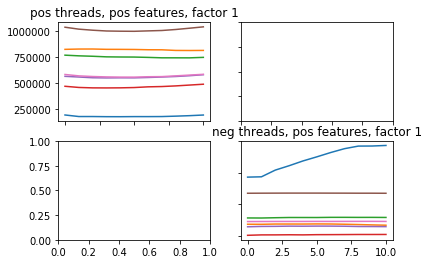

<Figure size 1800x1200 with 0 Axes>

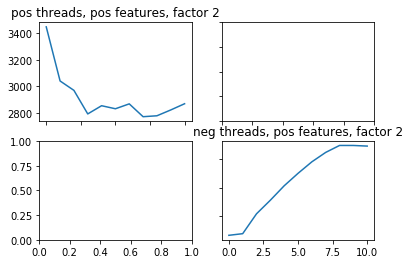

<Figure size 1800x1200 with 0 Axes>

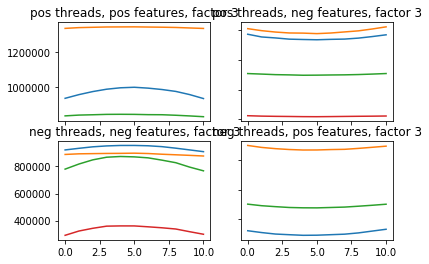

<Figure size 1800x1200 with 0 Axes>

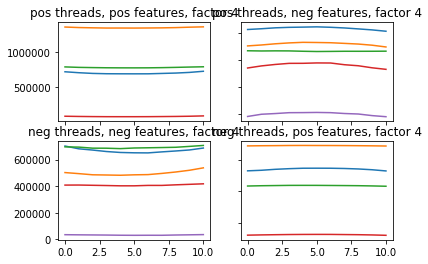

<Figure size 1800x1200 with 0 Axes>

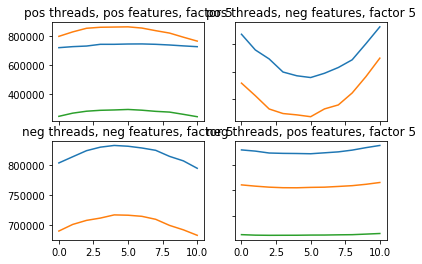

<Figure size 1800x1200 with 0 Axes>

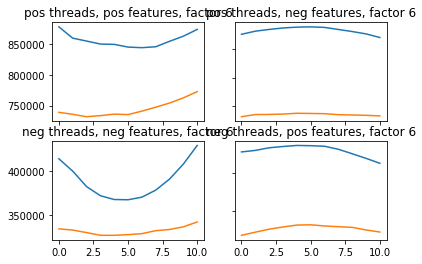

<Figure size 1800x1200 with 0 Axes>

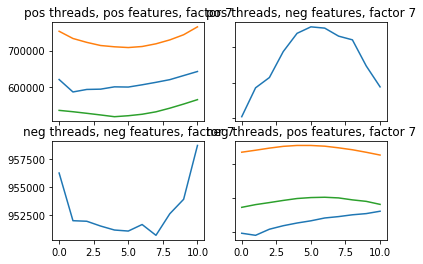

<Figure size 1800x1200 with 0 Axes>

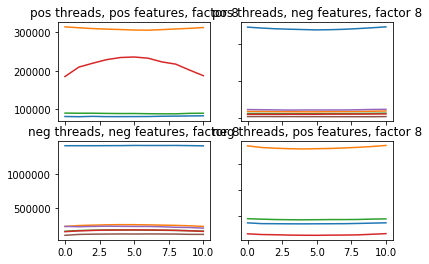

<Figure size 1800x1200 with 0 Axes>

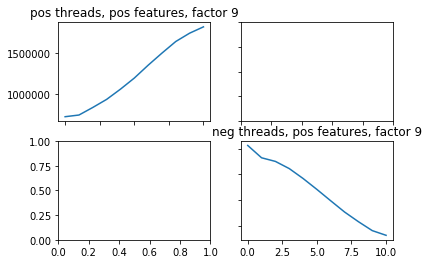

In [19]:
for i in range(max_rank):
    plot_trend(i)